# Step 1: cellranger postprocessing and initial QC
##### Requires cellranger processed scRNAseq results
- Combine SH libraries estimate doublets.
- Walk-through of initial QC thresholds (dataset-specific) with visualization.

##### This pipeline has to be run using the 'scanpy' conda environment
Somehow my scanpy conda environment got corrupted, and although I did rebuild it at one point, I don't see any reason why, moving forward, the R-based cellranger processing shouldn't be used instead. <br>
The raw files for the 4 SH libraries used in this analysis can be found at `/home/upstate/submission_data_GEO_Aug2023` (tarballed files). <br><br>
If you want to replicate the analysis used for the DevATLAS submission without running the code presented here, I have provided the CSV exports saved at the end of this analysis so that they can be used as input for the rest of the pipeline.


## Loading the libraries

In [1]:
import os
import scanpy as sc
import scrublet
import numpy as np
import scipy as sp
from scipy.sparse import csr_matrix
# import scvelo as scv
# import loompy as lp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sns
# from gprofiler import GProfiler
# from MulticoreTSNE import MulticoreTSNE as TSNE

# import rpy2.rinterface_lib.callbacks
# import logging

# from rpy2.robjects import pandas2ri
# import anndata2ri

ModuleNotFoundError: No module named 'scanpy'

Set up figure paramaters and expose the current package versions:

In [3]:
plt.rcParams['figure.figsize']=(8,8) #rescale figures

## FOr Scanpy
sc.settings.verbosity = 3
sc.set_figure_params(dpi=150, dpi_save=300)
sc.logging.print_header()

## for scVelo
scv.settings.verbosity = 3  # show errors(0), warnings(1), info(2), hints(3)
scv.settings.presenter_view = True  # set max width size for presenter view
scv.set_figure_params('scvelo')  # for beautified visualization
scv.logging.print_version()

scanpy==1.7.0 anndata==0.7.6 umap==0.3.10 numpy==1.18.1 scipy==1.4.1 pandas==0.25.3 scikit-learn==0.22.1 statsmodels==0.11.0 python-igraph==0.9.6 louvain==0.6.1 leidenalg==0.8.3
Running scvelo 0.2.2 (python 3.7.6) on 2021-08-17 10:13.


Add some additional pallettes:

In [4]:
from matplotlib import cm, colors

# Colorblindness adjusted vega_10
# See https://github.com/theislab/scanpy/issues/387
vega_10 = list(map(colors.to_hex, cm.tab10.colors))
vega_10_scanpy = vega_10.copy()
vega_10_scanpy[2] = '#279e68'  # green
vega_10_scanpy[4] = '#aa40fc'  # purple
vega_10_scanpy[8] = '#b5bd61'  # kakhi

# default matplotlib 2.0 palette
# see 'category20' on https://github.com/vega/vega/wiki/Scales#scale-range-literals
vega_20 = list(map(colors.to_hex, cm.tab20.colors))

# reorderd, some removed, some added
vega_20_scanpy = [
    *vega_20[0:14:2], *vega_20[16::2],  # dark without grey
    *vega_20[1:15:2], *vega_20[17::2],  # light without grey
    '#ad494a', '#8c6d31',  "#ff6df9",
"#004002",
"#ff318e", # manual additions
]
vega_20_scanpy[2] = vega_10_scanpy[2]
vega_20_scanpy[4] = vega_10_scanpy[4]
vega_20_scanpy[7] = vega_10_scanpy[8]  # kakhi shifted by missing grey
# TODO: also replace pale colors if necessary

zeileis_28 = [
    "#023fa5", "#7d87b9", "#bec1d4", "#d6bcc0", "#bb7784", "#8e063b", "#4a6fe3",
    "#8595e1", "#b5bbe3", "#e6afb9", "#e07b91", "#d33f6a", "#11c638", "#8dd593",
    "#c6dec7", "#ead3c6", "#f0b98d", "#ef9708", "#0fcfc0", "#9cded6", "#d5eae7",
    "#f3e1eb", "#f6c4e1", "#f79cd4",
    '#7f7f7f', "#c7c7c7", "#1CE6FF", "#336600",  # these last ones were added,
]

default_20 = zeileis_28

# Reading in the data
Because we have multiple samples, we'll need to concatenate and maintain samples identity. Later we'll also load the velocyto loom files, concatenate, and merge with the original AnnData object. We'll also later add the `Macosko_cell_cycle_genes.txt` file, which contains a list of marker genes for different cell cycle phases. section.


Load the 10X data:

In [2]:
#Data files
sample_strings = ['SH_P14_1', 'SH_P20_1', 'SH_P20_2', 'SH_P24']
#sample_strings = ['EE_P14', 'EE_P20_2', 'EE_P20_3', 'EE_P24']
file_base_start = 'cellranger_pipeline/run_cellranger_count_'
file_base_end = '/outs/filtered_feature_bc_matrix/'
data_file_end = 'matrix.mtx.gz'
barcode_file_end = 'barcodes.tsv.gz'
gene_file_end = 'features.tsv.gz'

In [3]:
# First data set load & annotation
#Parse Filenames
sample = sample_strings.pop(0)
data_file = file_base_start+sample+file_base_end+data_file_end
barcode_file = file_base_start+sample+file_base_end+barcode_file_end
gene_file = file_base_start+sample+file_base_end+gene_file_end

#Load data
adata = sc.read(data_file, cache=True, cache_compression='gzip')
adata = adata.transpose()
adata.X = adata.X.toarray()

barcodes = pd.read_csv(barcode_file, header=None, sep='\t', compression='gzip')
genes = pd.read_csv(gene_file, header=None, sep='\t', compression='gzip')

In [4]:
#Annotate data
barcodes.rename(columns={0:'barcode'}, inplace=True)
barcodes.set_index('barcode', inplace=True)
adata.obs = barcodes
adata.obs['sample'] = [sample]*adata.n_obs
adata.obs['environment'] = [sample.split("_")[0]]*adata.n_obs
adata.obs['age'] = [sample.split("_")[1]]*adata.n_obs

genes.rename(columns={0:'gene_id', 1:'gene_symbol'}, inplace=True)
#genes.set_index('gene_symbol', inplace=True)
genes.set_index('gene_id', inplace=True)
adata.var = genes
#adata.var_names_make_unique()

In [5]:
## Scrublet
adata.X = csr_matrix(adata.X)
# flag doublets
sc.external.pp.scrublet(adata)
# revert to array of counts
adata.X = adata.X.toarray()

Automatically set threshold at doublet score = 0.25
Detected doublet rate = 2.1%
Estimated detectable doublet fraction = 60.1%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 3.5%


Now loop over remaining sampels and concatenate:

In [6]:
# Loop to load rest of data sets
for i in range(len(sample_strings)):
    #Parse Filenames
    sample = sample_strings[i]
    data_file = file_base_start+sample+file_base_end+data_file_end
    barcode_file = file_base_start+sample+file_base_end+barcode_file_end
    gene_file = file_base_start+sample+file_base_end+gene_file_end
    
    #Load data
    adata_tmp = sc.read(data_file, cache=True, cache_compression='gzip')
    adata_tmp = adata_tmp.transpose()
    adata_tmp.X = adata_tmp.X.toarray()

    barcodes_tmp = pd.read_csv(barcode_file, header=None, sep='\t', compression='gzip')
    genes_tmp = pd.read_csv(gene_file, header=None, sep='\t', compression='gzip')
    
    #Annotate data
    barcodes_tmp.rename(columns={0:'barcode'}, inplace=True)
    barcodes_tmp.set_index('barcode', inplace=True)
    adata_tmp.obs = barcodes_tmp
    adata_tmp.obs['sample'] = [sample]*adata_tmp.n_obs
    adata_tmp.obs['environment'] = [sample.split("_")[0]]*adata_tmp.n_obs
    adata_tmp.obs['age'] = [sample.split("_")[1]]*adata_tmp.n_obs
    
    genes_tmp.rename(columns={0:'gene_id', 1:'gene_symbol'}, inplace=True)
    genes_tmp.set_index('gene_id', inplace=True)
    adata_tmp.var = genes_tmp
    adata_tmp.var_names_make_unique()
    
    ## Scrublet
    adata_tmp.X = csr_matrix(adata_tmp.X)
    # flag doublets
    sc.external.pp.scrublet(adata_tmp)
    # revert to array of counts
    adata_tmp.X = adata_tmp.X.toarray()
    
    # Concatenate to main adata object
    adata = adata.concatenate(adata_tmp, batch_key='sample_id')
    adata.obs.drop(columns=['sample_id'], inplace=True)
    adata.obs_names = [c.split("-")[0] for c in adata.obs_names]
    adata.obs_names_make_unique(join='_')
    
    

Automatically set threshold at doublet score = 0.22
Detected doublet rate = 4.1%
Estimated detectable doublet fraction = 64.6%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 6.4%
Automatically set threshold at doublet score = 0.33
Detected doublet rate = 1.5%
Estimated detectable doublet fraction = 48.4%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 3.0%
Automatically set threshold at doublet score = 0.21
Detected doublet rate = 4.0%
Estimated detectable doublet fraction = 64.6%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 6.2%


In [14]:
adata.shape

(33123, 31054)

# 2 Pre-processing and visualization

<a id="QC"></a>

## 2.1 Quality control

Data quality control can be split into cell QC and gene QC. Typical quality measures for assessing the quality of a cell include the number of molecule counts (UMIs), the number of expressed genes, and the fraction of counts that are mitochondrial. A high fraction of mitochondrial reads being picked up can indicate cell stress, as there is a low proportion of nuclear mRNA in the cell. It should be noted that high mitochondrial RNA fractions can also be biological signals indicating elevated respiration.

[Timing: 39.9s]

In [9]:
# Quality control - calculate QC covariates
adata.obs['n_counts'] = adata.X.sum(1)
adata.obs['log_counts'] = np.log(adata.obs['n_counts'])
adata.obs['n_genes'] = (adata.X > 0).sum(1)

mt_gene_mask = [gene.startswith('mt-') for gene in adata.var_names]
adata.obs['mt_frac'] = adata.X[:, mt_gene_mask].sum(1)/adata.obs['n_counts'] #fraction of counts that are from mt genes

... storing 'sample' as categorical
... storing 'environment' as categorical
... storing 'age' as categorical
... storing 'Age_group' as categorical


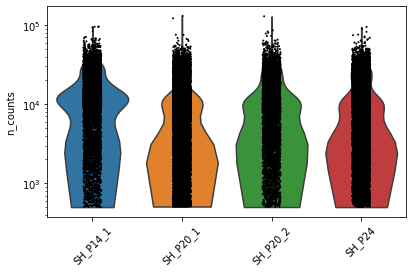

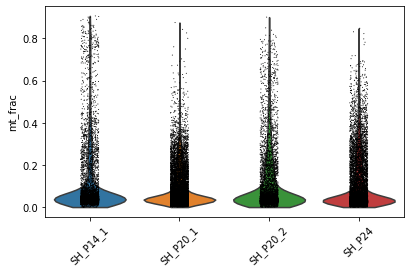

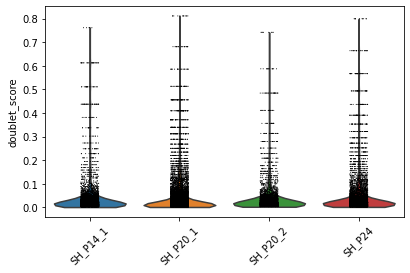

In [16]:
# Quality control - plot QC metrics
#Sample quality plots
t1 = sc.pl.violin(adata, 'n_counts', groupby='sample', size=2, log=True, cut=0, rotation = 45)
t2 = sc.pl.violin(adata, 'mt_frac', groupby='sample', rotation = 45)
t3 = sc.pl.violin(adata, 'doublet_score', groupby='sample', rotation = 45)

The plots show that the Jej_M2 sample has the poorest quality in comparison. The counts per cell are still sufficiently high to process these cells, and the fraction of mitochondrial reads (MT frac) for most cells are still far below 20-25%, which are the typical filtering thresholds.

We could perform QC filtering per sample here to address this issue, yet the mode of the distributions look similar to other samples (e.g., 'Il_M1'). It may be worth keeping in mind that one sample has a few poorer quality cells though.

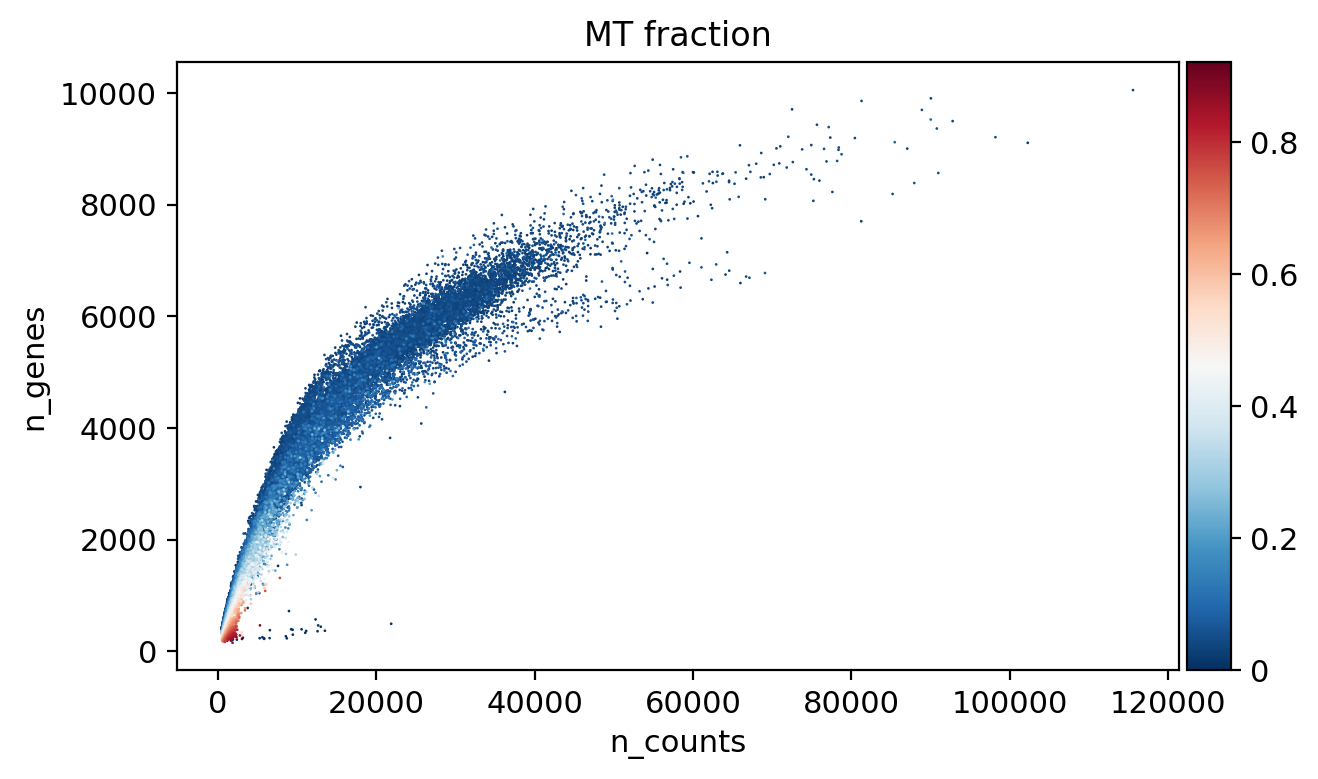

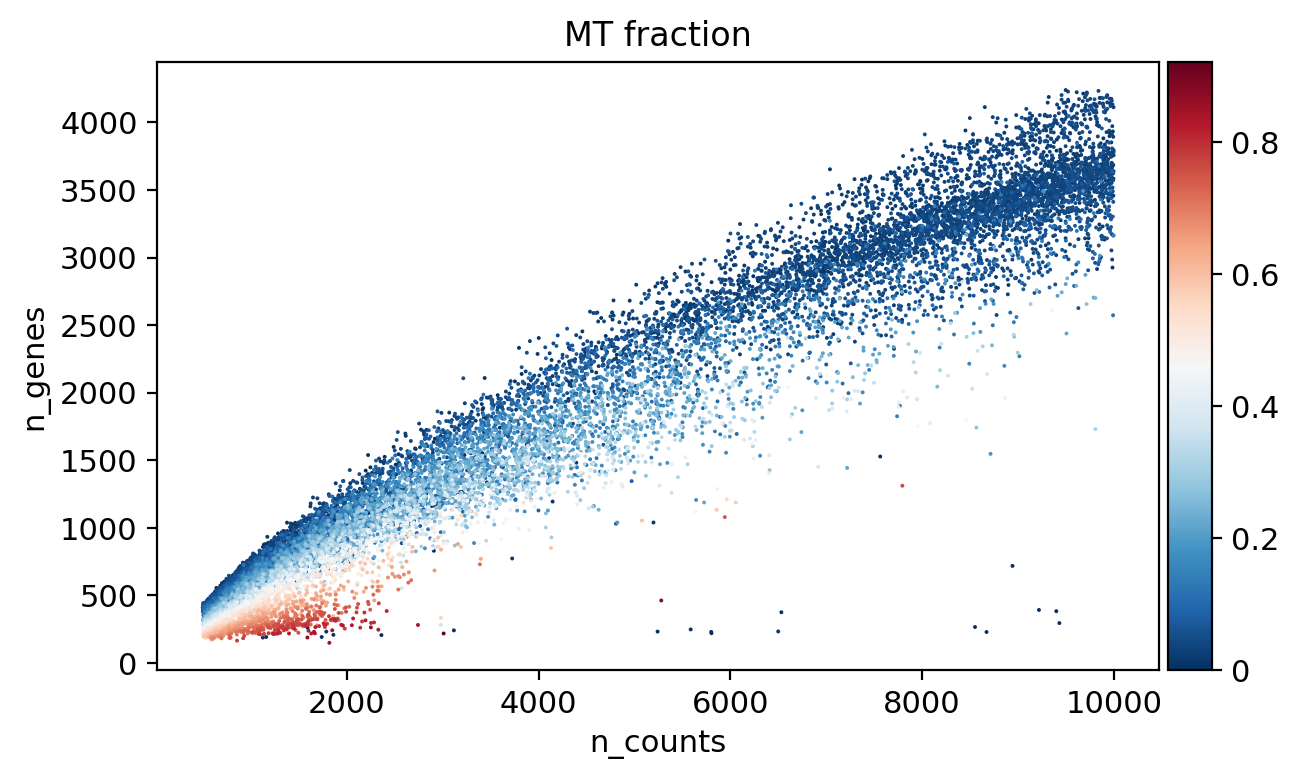

In [202]:
#Data quality summary plots
sc.pl.scatter(adata, 'n_counts', 'n_genes', color='mt_frac', title = 'MT fraction')
#p2 = sc.pl.scatter(adata[adata.obs['n_counts']<10000], 'n_counts', 'n_genes', color='mt_frac', title = 'MT fraction')

By looking at plots of the number of genes versus the number of counts with MT fraction information, we can assess whether there cells with unexpected summary statistics. It is important here to look at these statistics jointly. For example, there is a cloud of points with many counts, but few genes. Our first instinct would be to filter out these as "dying" outliers, however they don't seem to show high MT fraction. We should probably still filter out some cells with very few genes as these may be difficult to annotate later. This will be true for the initial cellular density between 1000-4000 counts and < ~500 genes.

Furthermore it can be seen in the main cloud of data points, that cells with lower counts and genes tend to have a higher fraction of mitochondrial counts. These cells are likely under stress or are dying. When apoptotic cells are sequenced, there is less mRNA to be captured in the nucleus, and therefore fewer counts overall, and thus a higher fraction of counts fall upon mitochondrial RNA. If cells with high mitochondrial activity were found at higher counts/genes per cell, this would indicate biologically relevant mitochondrial activity.

#### Doublet removal with Scrublet:

In [32]:
print(adata.obs['predicted_doublet'].value_counts())

False    20930
True       242
Name: predicted_doublet, dtype: int64


In [55]:
adata.obs['predicted_doublet'] = adata.obs['predicted_doublet'].values.astype(str)

... storing 'predicted_doublet' as categorical


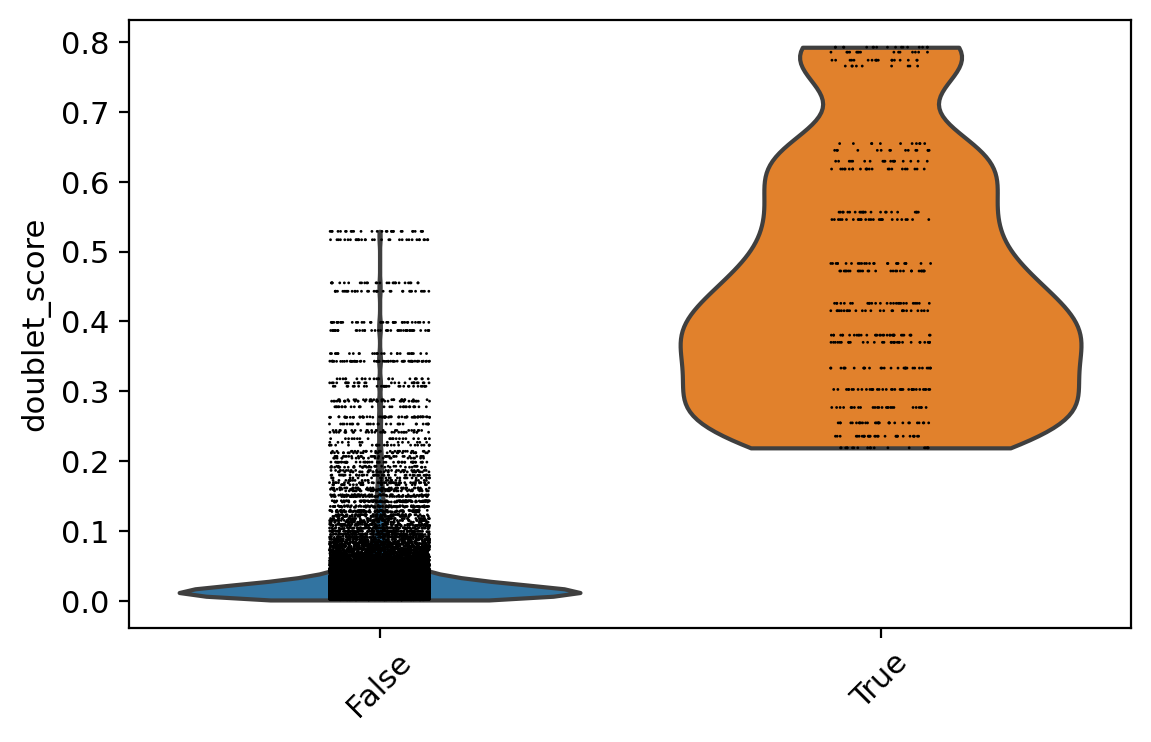

In [56]:
sc.pl.violin(adata, 'doublet_score', groupby='predicted_doublet', rotation = 45)

#### counts histograms:

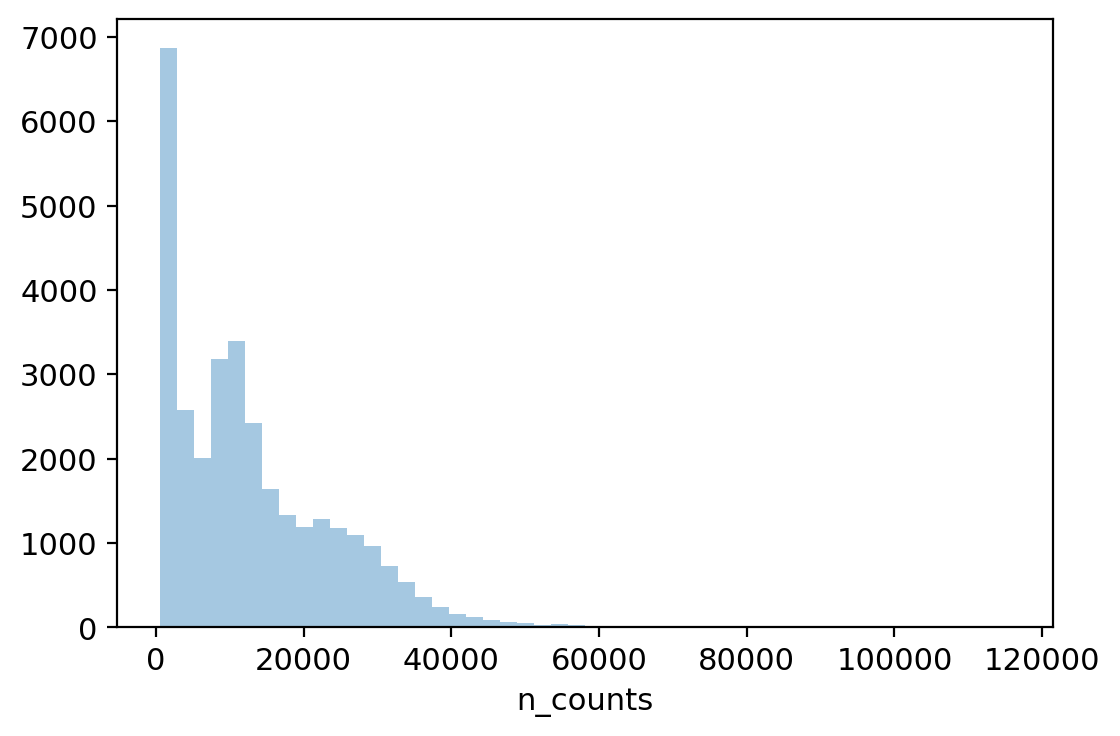

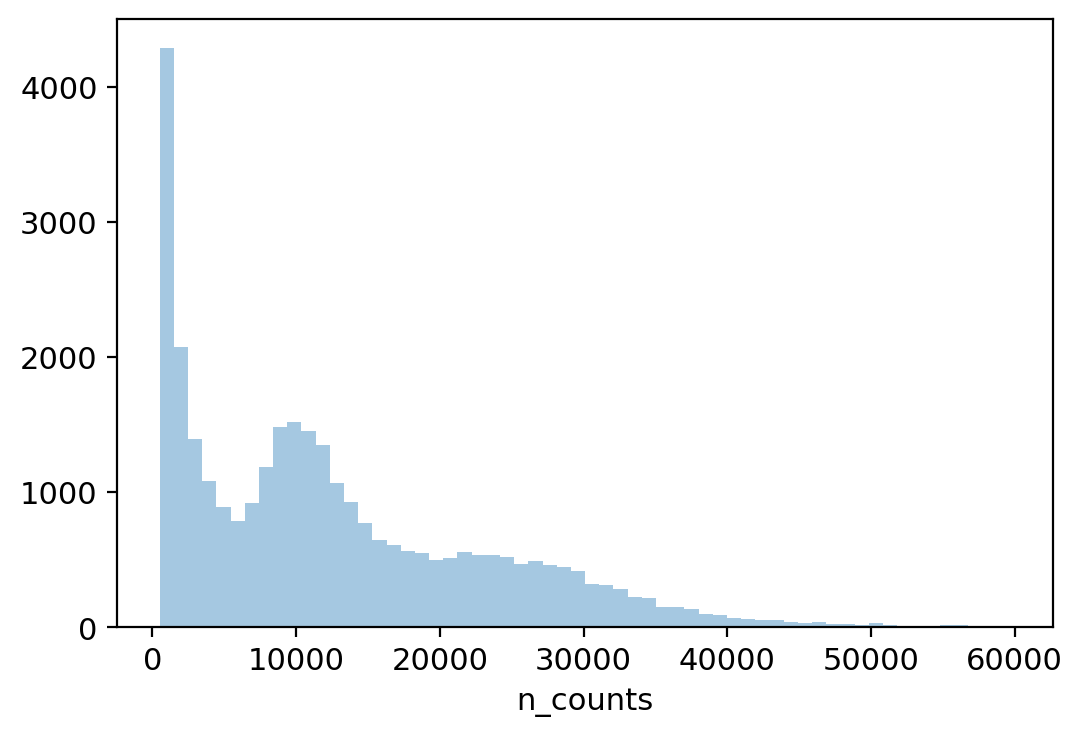

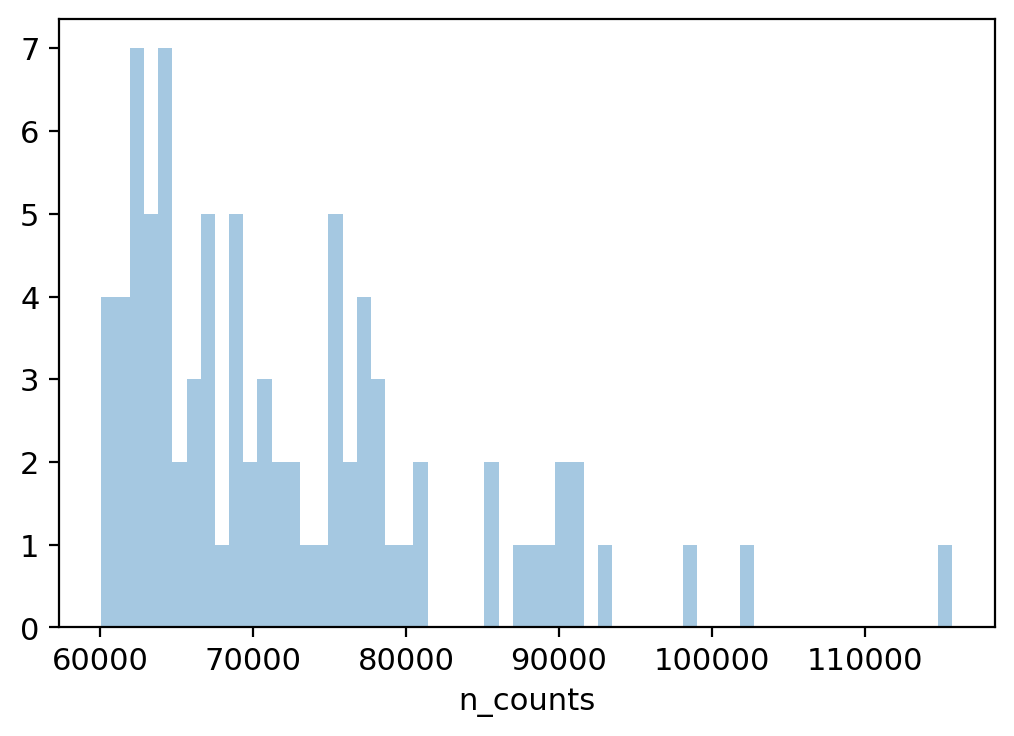

In [40]:
#Thresholding decision: counts
p3 = sns.distplot(adata.obs['n_counts'], kde=False)
plt.show()

p4 = sns.distplot(adata.obs['n_counts'][adata.obs['n_counts']<60000], kde=False, bins=60)
plt.show()

p5 = sns.distplot(adata.obs['n_counts'][adata.obs['n_counts']>60000], kde=False, bins=60)
plt.show()

Histograms of the number of counts per cell show that there are two small peaks of groups of cells with fewer than 1500 counts. which are likely uninformative given the overall distribution of counts. This may be cellular debris found in droplets.

On the upper end of counts, we see a population of cells with high counts shown as a broad peak at 20,000 counts. We estimate this population to range until 40,000 counts. This estimation is performed by visually tracing a Gaussian around the population.

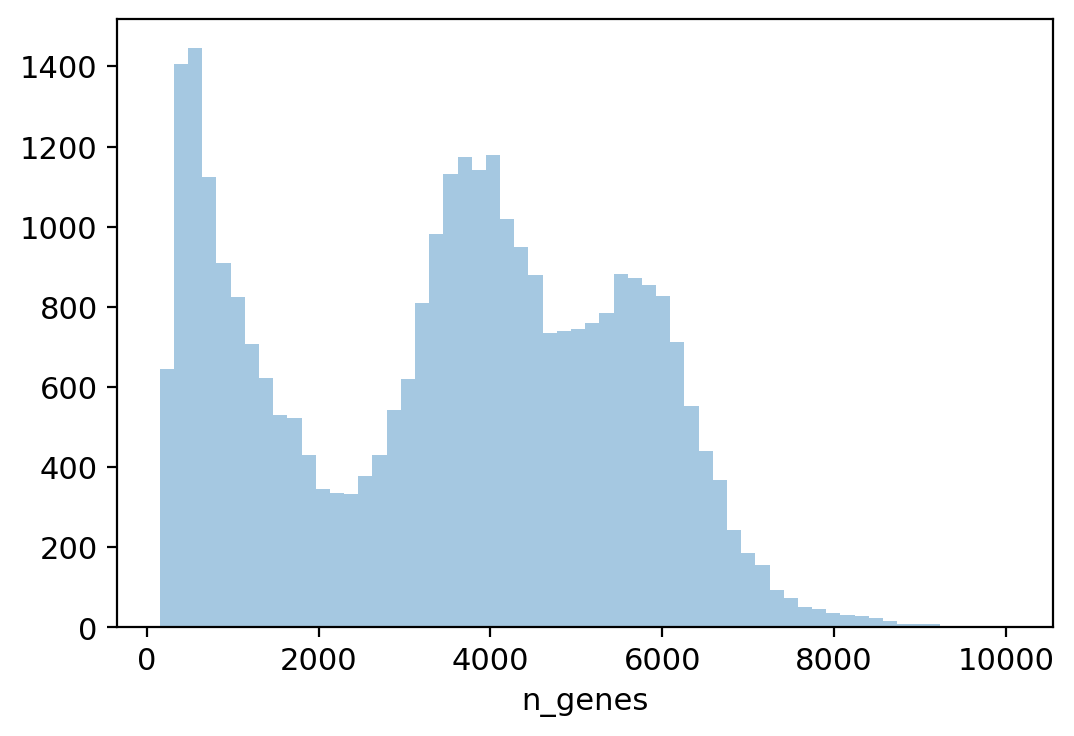

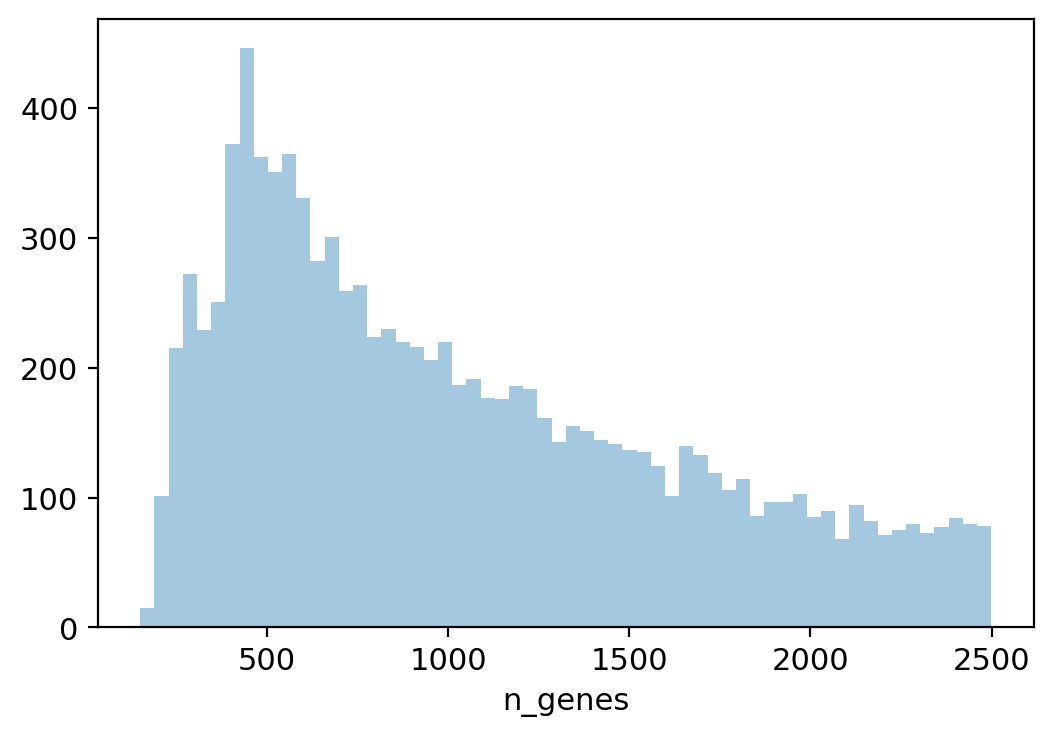

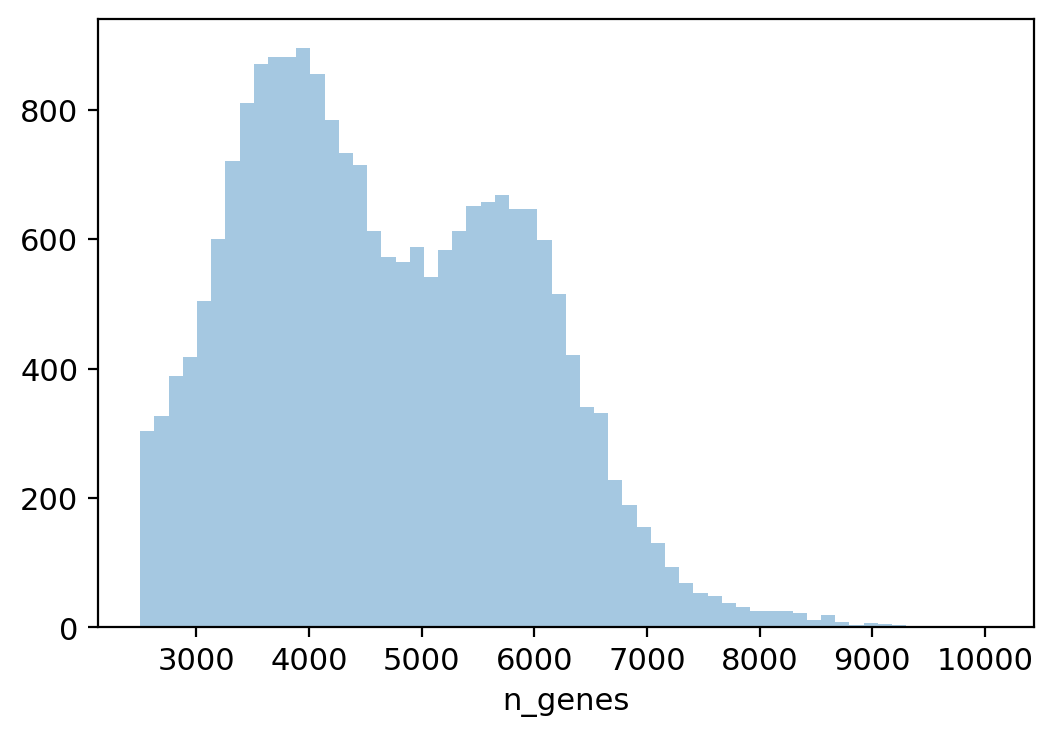

In [41]:
#Thresholding decision: genes
p6 = sns.distplot(adata.obs['n_genes'], kde=False, bins=60)
plt.show()

p7 = sns.distplot(adata.obs['n_genes'][adata.obs['n_genes']<2500], kde=False, bins=60)
plt.show()

p7 = sns.distplot(adata.obs['n_genes'][adata.obs['n_genes']>2500], kde=False, bins=60)
plt.show()


Two populations of cells with low gene counts can be seen in the above plots. Given these plots, and the plot of genes vs counts above, we decide to filter out cells with fewer than 700 genes expressed. Below this we are likely to find dying cells or empty droplets with ambient RNA. Looking above at the joint plots, we see that we filter out the main density of low gene cells with this threshold.

In general it is a good idea to be permissive in the early filtering steps, and then come back to filter out more stringently when a clear picture is available of what would be filtered out. This is available after visualization/clustering. For demonstration purposes we stick to a simple (and slightly more stringent) filtering here.

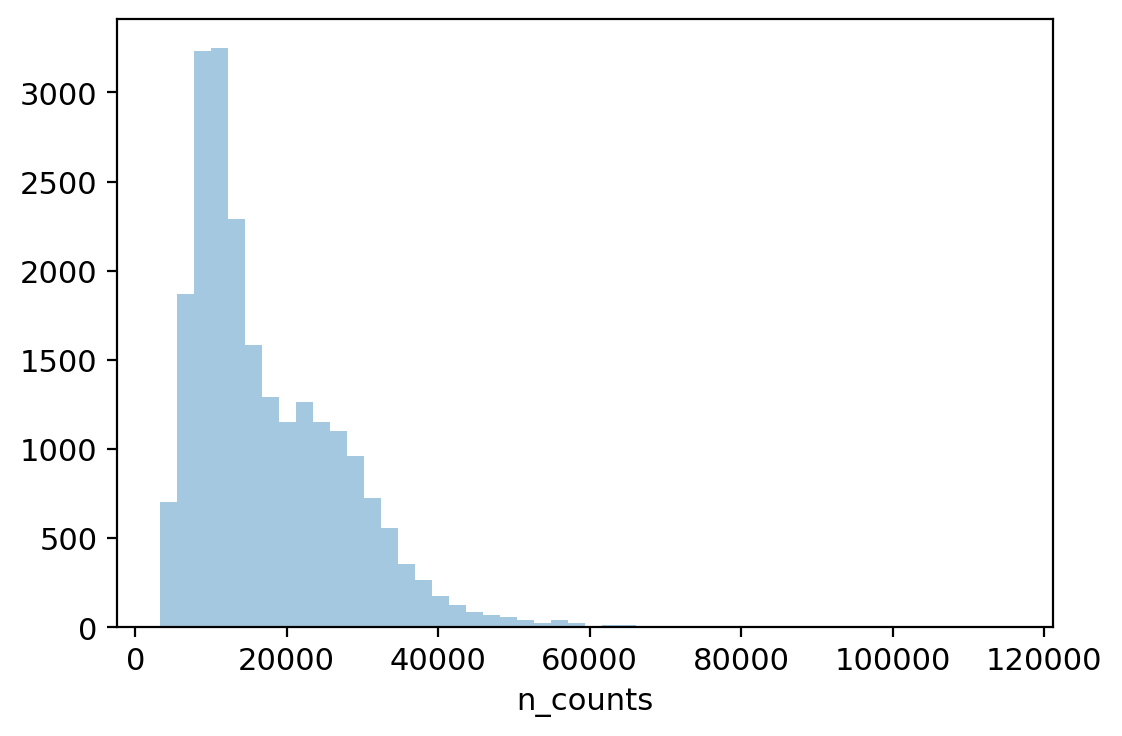

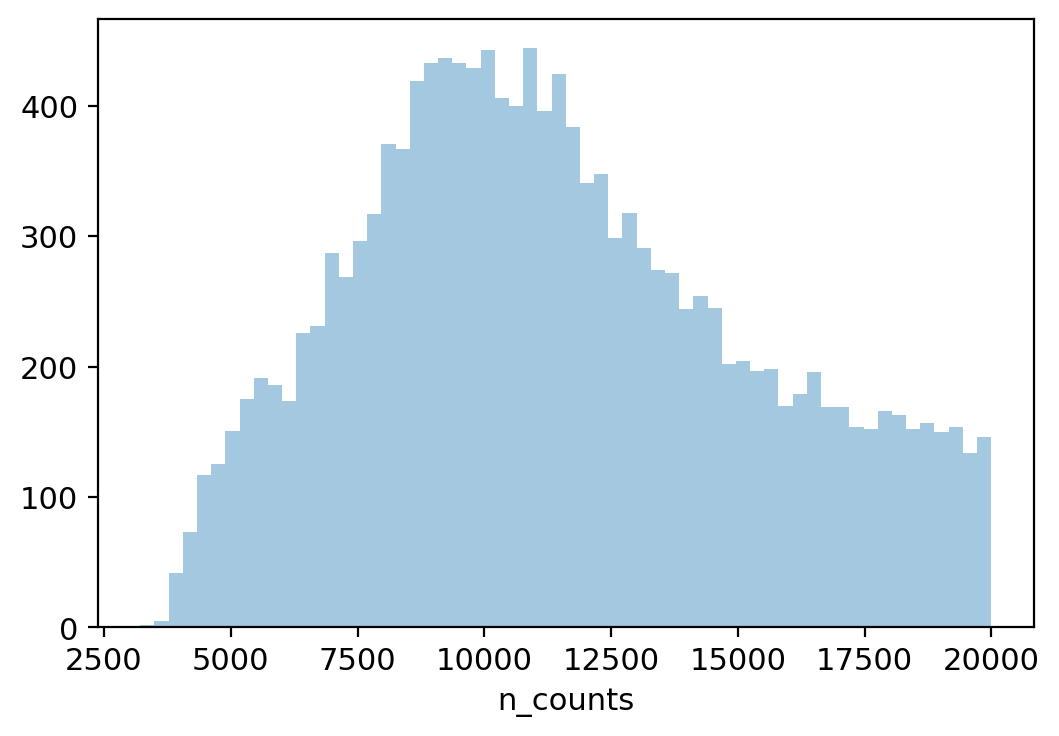

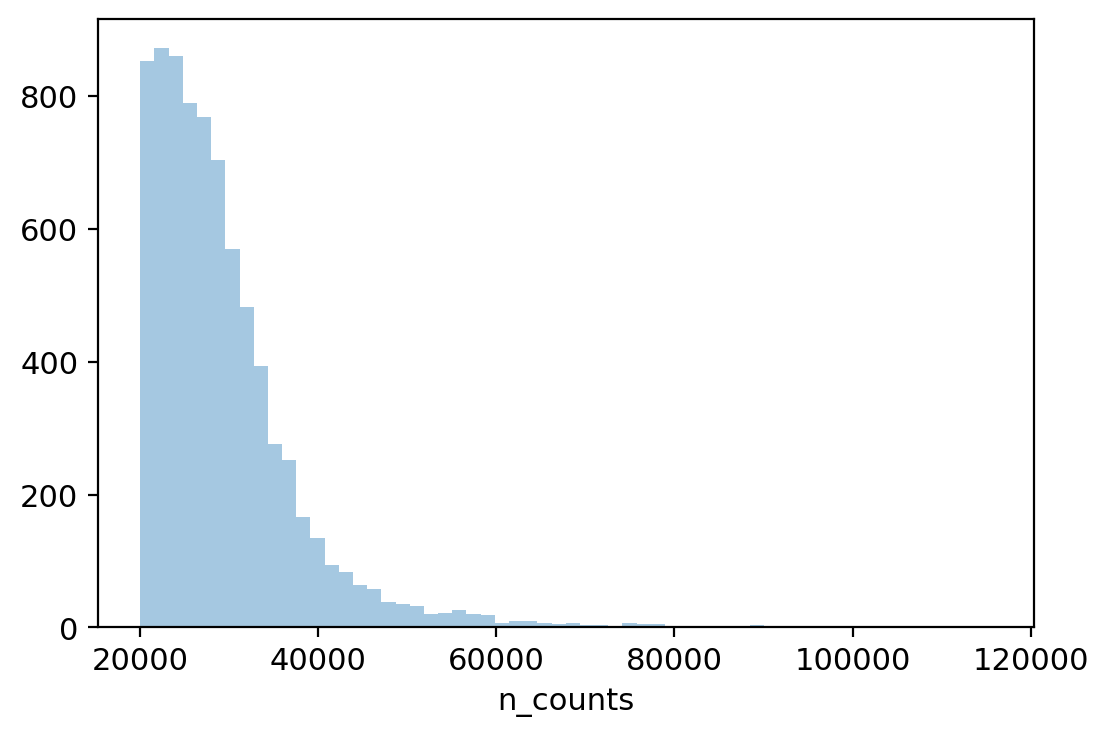

In [207]:
#Thresholding decision: counts
p3 = sns.distplot(ngenesfilt.obs['n_counts'], kde=False)
plt.show()

p4 = sns.distplot(ngenesfilt.obs['n_counts'][ngenesfilt.obs['n_counts']<20000], kde=False, bins=60)
plt.show()

p5 = sns.distplot(ngenesfilt.obs['n_counts'][ngenesfilt.obs['n_counts']>20000], kde=False, bins=60)
plt.show()

In [40]:
# Filter cells according to identified QC thresholds:
print('Total number of cells (adataJT): {:d}'.format(adata.n_obs))
print('')
adataJT = adataJT[adata.obs['predicted_doublet'] == False]
adataJT = adataJT[adata.obs['doublet_score'] < 0.35]
print('Number of cells after doublet exclusion (adataJT): {:d}'.format(adata.n_obs))
print('')
sc.pp.filter_cells(adata, min_genes = 2500)
print('Number of cells after gene filter (adataJT): {:d}'.format(adata.n_obs))
print('')
sc.pp.filter_cells(adata, max_counts = 60000)
print('Number of cells after max count filter (adataJT): {:d}'.format(adata.n_obs))
print('')
adataJT = adata[adata.obs['mt_frac'] < 0.10]
print('Number of cells after MT filter of .1 (adataJT): {:d}'.format(adata.n_obs))
print('')

Total number of cells (adataJT): 31715

Number of cells after doublet exclusion (adataJT): 30964



Trying to set attribute `.obs` of view, copying.


Number of cells after gene filter (adataJT): 21047

Number of cells after max count filter (adataJT): 20979

Number of cells after MT filter of .1 (adataJT): 20321



In [41]:
#Filter genes:
print('Total number of genes (adata): {:d}'.format(adata.n_vars))
print('')
# Min 3 cells - filters out 0 count genes
sc.pp.filter_genes(adata, min_cells=3)
print('Number of genes after cell filter (adata): {:d}'.format(adataJT.n_vars))

Total number of genes (adata): 31054



Trying to set attribute `.var` of view, copying.


Number of genes after cell filter (adata): 21817


In [42]:
# Checking the total size of the data set
adata.shape

(20321, 21817)

#### Check the plots after filtering:

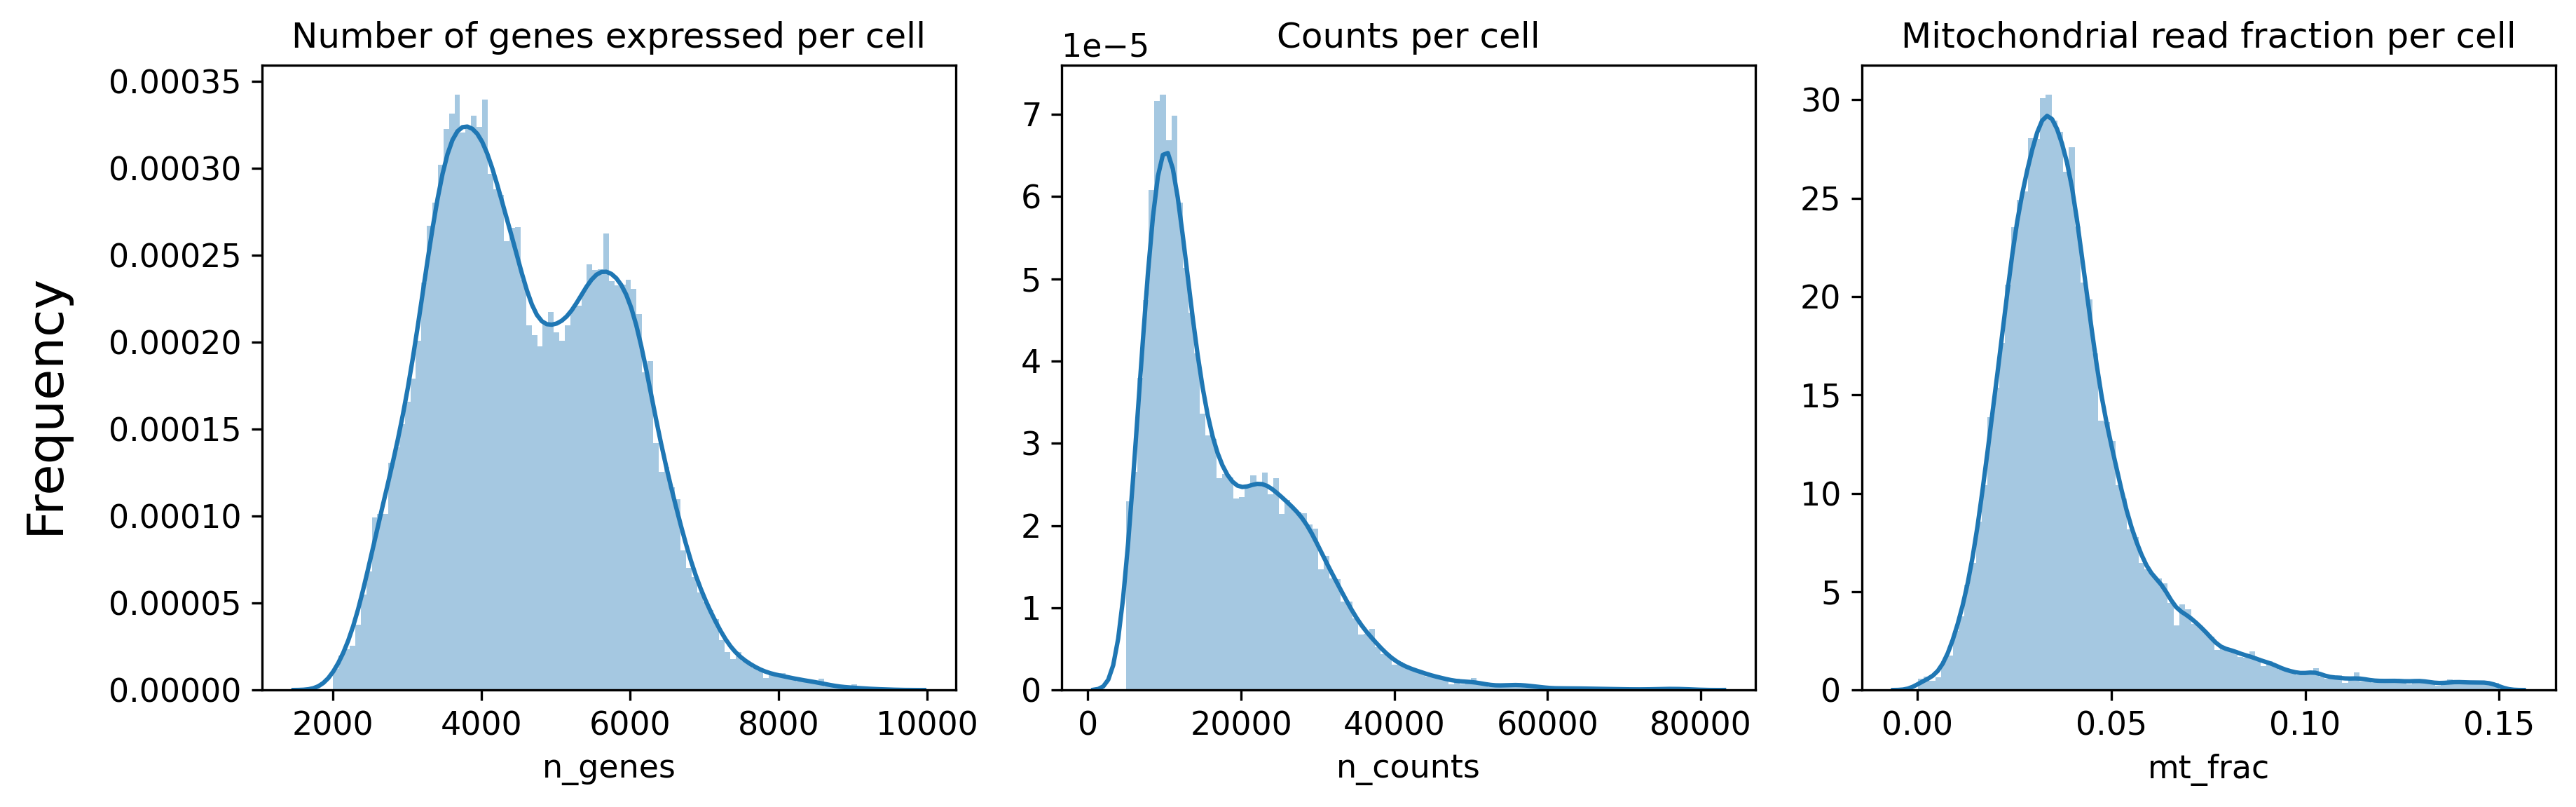

In [224]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), dpi=150, sharey=False)

adata.obs['n_genes']

sns.distplot( adata.obs['n_genes'], ax=ax1, norm_hist=True, bins=100)
sns.distplot( adata.obs['n_counts'], ax=ax2, norm_hist=True, bins=100)
sns.distplot( adata.obs['mt_frac'], ax=ax3, norm_hist=True, bins=100)

ax1.title.set_text('Number of genes expressed per cell')
ax2.title.set_text('Counts per cell')
ax3.title.set_text('Mitochondrial read fraction per cell')

fig.text(-0.01, 0.5, 'Frequency', ha='center', va='center', rotation='vertical', size='x-large')

fig.tight_layout()

#fig.savefig('filtering_panel_postfilter_.pdf', dpi=600, bbox_inches='tight')
plt.show()

In [43]:
adata.layers["counts"] = adata.X.copy()

In [44]:
adata.write("processed-data/mm_dg_processed.h5ad")

... storing 'sample' as categorical
... storing 'environment' as categorical
... storing 'age' as categorical
... storing 'Age_group' as categorical


In [59]:
np.savetxt("processed-data/Counts_raw_filters-2500-60000.csv", 
           adata.layers['counts'].T, delimiter=",")

In [53]:
adata.obs.to_csv("processed-data/Obs_filters-2500-60000.csv")
adata.var.to_csv("processed-data/Var_filters-2500-60000.csv")

The filtering is performed based on the thresholds we identified from the QC plots. Genes are also filtered if they are not detected in at least 20 cells. This reduces the dimensions of the matrix by removing 0 count genes and genes which are not sufficiently informative of the dataset. 